In [2]:
import sys
import os

import operator

class NullWriter(object):
    def write(self, arg):
        pass

class DevNull:
    def write(self, msg):
        pass
    
oldstderr = sys.stderr
oldstdout = sys.stdout

sys.path.append('..')
import copy

import cobra
import escher
import pandas as pd
import timeit
import time
#import seaborn

import matplotlib.pyplot as plt
import numpy as np

import cameo

from cameo import fba
from cameo import pfba
#from cameo import moma



from excel_read import read_excel
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.style.use("bmh")

%matplotlib notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.precision = 10

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: goldenrod' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the minimum in a Series ligthblue.
    '''
    is_min = s == s.min()
    return ['background-color: blue' if v else '' for v in is_min]

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, green otherwise.
    """
    color = 'red' if val < 0 else 'green'
    return 'background-color: %s' % color

In [3]:
match_list = {"Alanine" : "EX_ala(e)",
              "Arginine" : "EX_arg(e)",
              'Asparagine' : "EX_asn(e)",
              'Aspartic Acid' : "EX_asp(e)",
              'Ca pantothenate' : "None",
              'CaCl2' : "None",
              'Cholesterol' : 'EX_clr(e)',
              'Choline chloride' : 'EX_choline(e)',
              'CuSO4' : "None",
              'Cysteine' : 'EX_cys(e)',
              'FeSO4' : "None",
              'Glacial acetic acid' : "None",
              'Glutamate' : 'EX_glu-L(e)', 
              'Glutamine' : 'EX_gln-L(e)',
              'Glycine' : 'EX_gly(e)', 
              'Histidine' : 'EX_his(e)',
              'Inosine' : 'EX_i(e)',
              'Isoleucine' : 'EX_ile(e)',
              'KH2PO4' : "None",
              'Leucine' : 'EX_leu(e)',
              'Lysine' : 'EX_lys(e)',
              'Methionine' : 'EX_met(e)',
              'MgSO4' : "None",
              'MnCl2' : "None",
              'Myo-inositol' : 'EX_ins(e)',
              'NaHCO3' : "None",
              'Nicotinic acid' : "None",
              'Nipagin' : "None",
              'Phenylalanine' : 'EX_phe(e)',
              'Proline' : 'EX_pro(e)',
              'Propionic acid' : "None",
              'Riboflavin' : 'EX_RIBFLV(e)',
              'Serine' : 'EX_ser(e)',
              'Sodium folate' : "None",
              'Sucrose' : 'EX_sucr',
              'Thiamine' : "None",
              'Threonine' : 'EX_thr(e)',
              'Tryptophan' : 'EX_trp(e)',
              'Tyrosine' : 'EX_tyr(e)',
              'Uridine' : 'EX_urd(e)',
              'Valine' : 'EX_val(e)',
              'Water' : "None",
              'ZnSO4' : "None",
              'biotine' : "None",
              'pyridoxine' : "None"}

In [4]:
%time m = read_excel("../FlySilico_v1.xls") #read xls-File in our shape
m.compartments = {'c': 'cytosol','e': 'extracellular','m': 'mitochondria'}

m.reactions.get_by_id("BIOMASS").objective_coefficient = 1

m.description = "FlySilico 1.0 - A Drosophila melanogaster metabolic network. Authors: Lisa Jehrke, Mathias Beller, and Juergen Schoenborn\
[Institute of mathematical modelling of biological systems - Work group: Systems biology of lipid metabolism, Heinrich Heine University Duesseldorf]"

%time cobra.io.write_sbml_model(m, "../FBA_Dmel.xml") #"convert" xls into sbml

%time m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo #cameo.load_model(
cobra.io.save_json_model(m, "../FBA_Dmel_mapdata.json")

Academic license - for non-commercial use only
Wall time: 1.46 s
Wall time: 98 ms
Wall time: 262 ms


In [5]:
#with cameo and gurobi installed, gurobi is the standard solver

m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
print "erstelle loopless model"
cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model

%time fba_result = fba(m) #fba result of the model
print "done - normal FBA"
%time fba_result_loopless = fba(m_loopless) #fba result of the loopless model
print "done - loopless FBA"

print m.summary(fva=1)
m_loopless.summary(fva=1)

Read LP format model from file c:\users\admin\appdata\local\temp\tmppoypie.lp
Reading time = 0.01 seconds
: 293 rows, 726 columns, 2516 nonzeros
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Parameter Method unchanged
   Value: 0  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
erstelle loopless model
Wall time: 22 ms
done - normal FBA
Wall time: 920 ms
done - loopless FBA
IN FLUXES                                  OUT FLUXES                                   OBJECTIVES
-----------------------------------------  -------------------------------------------  --------------
id             Flux  Range                 id               Flux  Range                 BIOMASS  0.088
---------  --------  --------------------  -----------  --------  --------------------
thr[e]     0.481     [0.481, 0.481]        co2[e]       0.607     [0, 34.6]
o2[e]      0.427     [0.393, 37.4]         gly[e]       0

In [6]:
up_t_EAA = pd.read_csv("../Uptake_Calc/uptake_2xEAA.csv")
up_t_EAA.set_index("Unnamed: 0",inplace=True)

up_t_suc = pd.read_csv("../Uptake_Calc/uptake_2xsuc.csv")
up_t_suc.set_index("Unnamed: 0",inplace=True)


In [7]:
reaction = "EX_asp(e)"
label = "Aspartic acid"
points =100
end = .004
start = -.004

#def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
start_time = timeit.default_timer()
    
print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
if points < 1:
    points = 1
    
    

sys.stdout = NullWriter() # disable output
sys.stderr = DevNull()
    
m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
sys.stderr = oldstderr
sys.stdout = oldstdout # enable output
    
growth = []
growth_ll = []
growth_ll_alt = []
meta = []
meta_alt = []

rnd = 0 #only counter
rnd2 = 0 #only counter
linspace = np.linspace(start,end,points)
if np.sign(start) != np.sign(end):
    linspace = np.sort(np.append(linspace,0))

for i in linspace:
    
    rnd2 += 1 
    if rnd2 > rnd:
        rnd += 50
        print i
    
    m.reactions.get_by_id(reaction).lower_bound = -i
    m.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).lower_bound = -i
    meta += [i]
    
    try: # to avoid infeasable solutions
        fba_result = fba(m) #fba result of the model
        growth += [fba_result.objective_value]
    except: # if infeasable, add growth rate of 0
        growth += [0]
        
    try: # to avoid infeasable solutions
        fba_result_loopless = fba(m_loopless) #fba result of the loopless model
        growth_ll += [fba_result_loopless.objective_value]
    except: # if infeasable, add growth rate of 0
        growth_ll += [0]
        
asp_plot_data = [meta,growth_ll]

#########################################################################################################################

points =100
end = 1.2
start = -.2

start_time = timeit.default_timer()
    
print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
if points < 1:
    points = 1
    
    

sys.stdout = NullWriter() # disable output
sys.stderr = DevNull()
    
m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
sys.stderr = oldstderr
sys.stdout = oldstdout # enable output
    
growth = []
growth_ll = []
growth_ll_alt = []
meta = []
meta_alt = []

rnd = 0 #only counter
rnd2 = 0 #only counter
linspace = np.linspace(start,end,points)
if np.sign(start) != np.sign(end):
    linspace = np.sort(np.append(linspace,0))

for i in linspace:
    
    rnd2 += 1 
    if rnd2 > rnd:
        rnd += 50
        print i
    
    m.reactions.get_by_id(reaction).lower_bound = -i
    m.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).lower_bound = -i
    meta += [i]
    
    try: # to avoid infeasable solutions
        fba_result = fba(m) #fba result of the model
        growth += [fba_result.objective_value]
    except: # if infeasable, add growth rate of 0
        growth += [0]
        
    try: # to avoid infeasable solutions
        fba_result_loopless = fba(m_loopless) #fba result of the loopless model
        growth_ll += [fba_result_loopless.objective_value]
    except: # if infeasable, add growth rate of 0
        growth_ll += [0]

asp_plot_data_inset = [meta,growth_ll]
#########################################################################################################################
reaction = "EX_clr(e)"
label = "Cholesterol"
points =100
end = .0016
start = -.0002

#def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
start_time = timeit.default_timer()
    
print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
if points < 1:
    points = 1
    
    

sys.stdout = NullWriter() # disable output
sys.stderr = DevNull()
    
m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
sys.stderr = oldstderr
sys.stdout = oldstdout # enable output
    
growth = []
growth_ll = []
growth_ll_alt = []
meta = []
meta_alt = []

rnd = 0 #only counter
rnd2 = 0 #only counter
linspace = np.linspace(start,end,points)
if np.sign(start) != np.sign(end):
    linspace = np.sort(np.append(linspace,0))

for i in linspace:
    
    rnd2 += 1 
    if rnd2 > rnd:
        rnd += 50
        print i
    
    m.reactions.get_by_id(reaction).lower_bound = -i
    m.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).lower_bound = -i
    meta += [i]
    
    try: # to avoid infeasable solutions
        fba_result = fba(m) #fba result of the model
        growth += [fba_result.objective_value]
    except: # if infeasable, add growth rate of 0
        growth += [0]
        
    try: # to avoid infeasable solutions
        fba_result_loopless = fba(m_loopless) #fba result of the loopless model
        growth_ll += [fba_result_loopless.objective_value]
    except: # if infeasable, add growth rate of 0
        growth_ll += [0]
        
clr_plot_data = [meta,growth_ll]

#########################################################################################################################

points =100
end = 1.2
start = -.2

start_time = timeit.default_timer()
    
print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
if points < 1:
    points = 1
    
    

sys.stdout = NullWriter() # disable output
sys.stderr = DevNull()
    
m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
sys.stderr = oldstderr
sys.stdout = oldstdout # enable output
    
growth = []
growth_ll = []
growth_ll_alt = []
meta = []
meta_alt = []

rnd = 0 #only counter
rnd2 = 0 #only counter
linspace = np.linspace(start,end,points)
if np.sign(start) != np.sign(end):
    linspace = np.sort(np.append(linspace,0))

for i in linspace:
    
    rnd2 += 1 
    if rnd2 > rnd:
        rnd += 50
        print i
    
    m.reactions.get_by_id(reaction).lower_bound = -i
    m.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).lower_bound = -i
    meta += [i]
    
    try: # to avoid infeasable solutions
        fba_result = fba(m) #fba result of the model
        growth += [fba_result.objective_value]
    except: # if infeasable, add growth rate of 0
        growth += [0]
        
    try: # to avoid infeasable solutions
        fba_result_loopless = fba(m_loopless) #fba result of the loopless model
        growth_ll += [fba_result_loopless.objective_value]
    except: # if infeasable, add growth rate of 0
        growth_ll += [0]

clr_plot_data_inset = [meta,growth_ll]
#########################################################################################################################

reaction = "EX_o2"
label = "Oxygen"
points = 100
end = 1.2
start = -0.2


start_time = timeit.default_timer()
    
print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
if points < 1:
    points = 1
    
    

sys.stdout = NullWriter() # disable output
sys.stderr = DevNull()
    
m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
sys.stderr = oldstderr
sys.stdout = oldstdout # enable output
    
growth = []
growth_ll = []
growth_ll_alt = []
meta = []
meta_alt = []

rnd = 0 #only counter
rnd2 = 0 #only counter
linspace = np.linspace(start,end,points)
if np.sign(start) != np.sign(end):
    linspace = np.sort(np.append(linspace,0))
        
for i in linspace:
    
    rnd2 += 1 
    if rnd2 > rnd:
        rnd += 50
        print i
    
    m.reactions.get_by_id(reaction).lower_bound = -i
    m.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).lower_bound = -i
    meta += [i]
    
    try: # to avoid infeasable solutions
        fba_result = fba(m) #fba result of the model
        growth += [fba_result.objective_value]
    except: # if infeasable, add growth rate of 0
        growth += [0]
        
    try: # to avoid infeasable solutions
        fba_result_loopless = fba(m_loopless) #fba result of the loopless model
        growth_ll += [fba_result_loopless.objective_value]
    except: # if infeasable, add growth rate of 0
        growth_ll += [0]

###############################################################
rnd = 0 #only counter
rnd2 = 0 #only counter
    
%time m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
print "erstelle loopless model"
cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
for test in match_list:
    if match_list[test] != "None":

        m.reactions.get_by_id(match_list[test]).lower_bound = -float(up_t_suc.loc[test]["0.122"])
        m_loopless.reactions.get_by_id(match_list[test]).lower_bound = -float(up_t_suc.loc[test]["0.122"])
    
    
for z in linspace:
    
    rnd2 += 1 
    if rnd2 > rnd:
        print z
        rnd += 50
    
    m.reactions.get_by_id(reaction).lower_bound = -z
    m.reactions.get_by_id(reaction).upper_bound = -z
    m_loopless.reactions.get_by_id(reaction).upper_bound = -z
    m_loopless.reactions.get_by_id(reaction).lower_bound = -z
    meta_alt += [z]
        
    try: # to avoid infeasable solutions
        fba_result_loopless = fba(m_loopless) #fba result of the loopless model
        growth_ll_alt += [fba_result_loopless.objective_value]
    except: # if infeasable, add growth rate of 0
        growth_ll_alt += [0]   

#########################################################################################################################

suc_plot_data = [meta,growth_ll,growth_ll_alt]

#########################################################################################################################
reaction = "EX_o2"
label = "Oxygen"
points = 100
end = 1.2
start = -0.2


start_time = timeit.default_timer()
    
print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
if points < 1:
    points = 1
    
    

sys.stdout = NullWriter() # disable output
sys.stderr = DevNull()
    
m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
sys.stderr = oldstderr
sys.stdout = oldstdout # enable output
    
growth = []
growth_ll = []
growth_ll_alt = []
meta = []
meta_alt = []

rnd = 0 #only counter
rnd2 = 0 #only counter
linspace = np.linspace(start,end,points)
if np.sign(start) != np.sign(end):
    linspace = np.sort(np.append(linspace,0))
        
for i in linspace:
    
    rnd2 += 1 
    if rnd2 > rnd:
        rnd += 50
        print i
    
    m.reactions.get_by_id(reaction).lower_bound = -i
    m.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).upper_bound = -i
    m_loopless.reactions.get_by_id(reaction).lower_bound = -i
    meta += [i]
    
    try: # to avoid infeasable solutions
        fba_result = fba(m) #fba result of the model
        growth += [fba_result.objective_value]
    except: # if infeasable, add growth rate of 0
        growth += [0]
        
    try: # to avoid infeasable solutions
        fba_result_loopless = fba(m_loopless) #fba result of the loopless model
        growth_ll += [fba_result_loopless.objective_value]
    except: # if infeasable, add growth rate of 0
        growth_ll += [0]

###############################################################
rnd = 0 #only counter
rnd2 = 0 #only counter
    
%time m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
print "erstelle loopless model"
cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
for test in match_list:
    if match_list[test] != "None":

        m.reactions.get_by_id(match_list[test]).lower_bound = -float(up_t_EAA.loc[test]["0.122"])
        m_loopless.reactions.get_by_id(match_list[test]).lower_bound = -float(up_t_EAA.loc[test]["0.122"])
    
    
for z in linspace:
    
    rnd2 += 1 
    if rnd2 > rnd:
        print z
        rnd += 50
    
    m.reactions.get_by_id(reaction).lower_bound = -z
    m.reactions.get_by_id(reaction).upper_bound = -z
    m_loopless.reactions.get_by_id(reaction).upper_bound = -z
    m_loopless.reactions.get_by_id(reaction).lower_bound = -z
    meta_alt += [z]
        
    try: # to avoid infeasable solutions
        fba_result_loopless = fba(m_loopless) #fba result of the loopless model
        growth_ll_alt += [fba_result_loopless.objective_value]
    except: # if infeasable, add growth rate of 0
        growth_ll_alt += [0]   
############################################################### 

eaa_plot_data = [meta,growth_ll,growth_ll_alt]

#########################################################################################################################



###################### 
Graph for Aspartic acid
-0.004
0.0
0.004

###################### 
Graph for Aspartic acid
-0.2
0.49292929292929283
1.2

#################### 
Graph for Cholesterol
-0.0002
0.000690909090909091
0.0016

#################### 
Graph for Cholesterol
-0.2
0.49292929292929283
1.2

############### 
Graph for Oxygen
-0.2
0.49292929292929283
1.2
Wall time: 265 ms
Read LP format model from file c:\users\admin\appdata\local\temp\tmpjnpxef.lp
Reading time = 0.01 seconds
: 293 rows, 726 columns, 2516 nonzeros
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Parameter Method unchanged
   Value: 0  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
erstelle loopless model
-0.2
0.49292929292929283
1.2

############### 
Graph for Oxygen
-0.2
0.49292929292929283
1.2
Wall time: 257 ms
Read LP format model from file c:\users\admin\appdata\local\temp\tmpmw_oih.lp
Reading time = 0.01 seconds


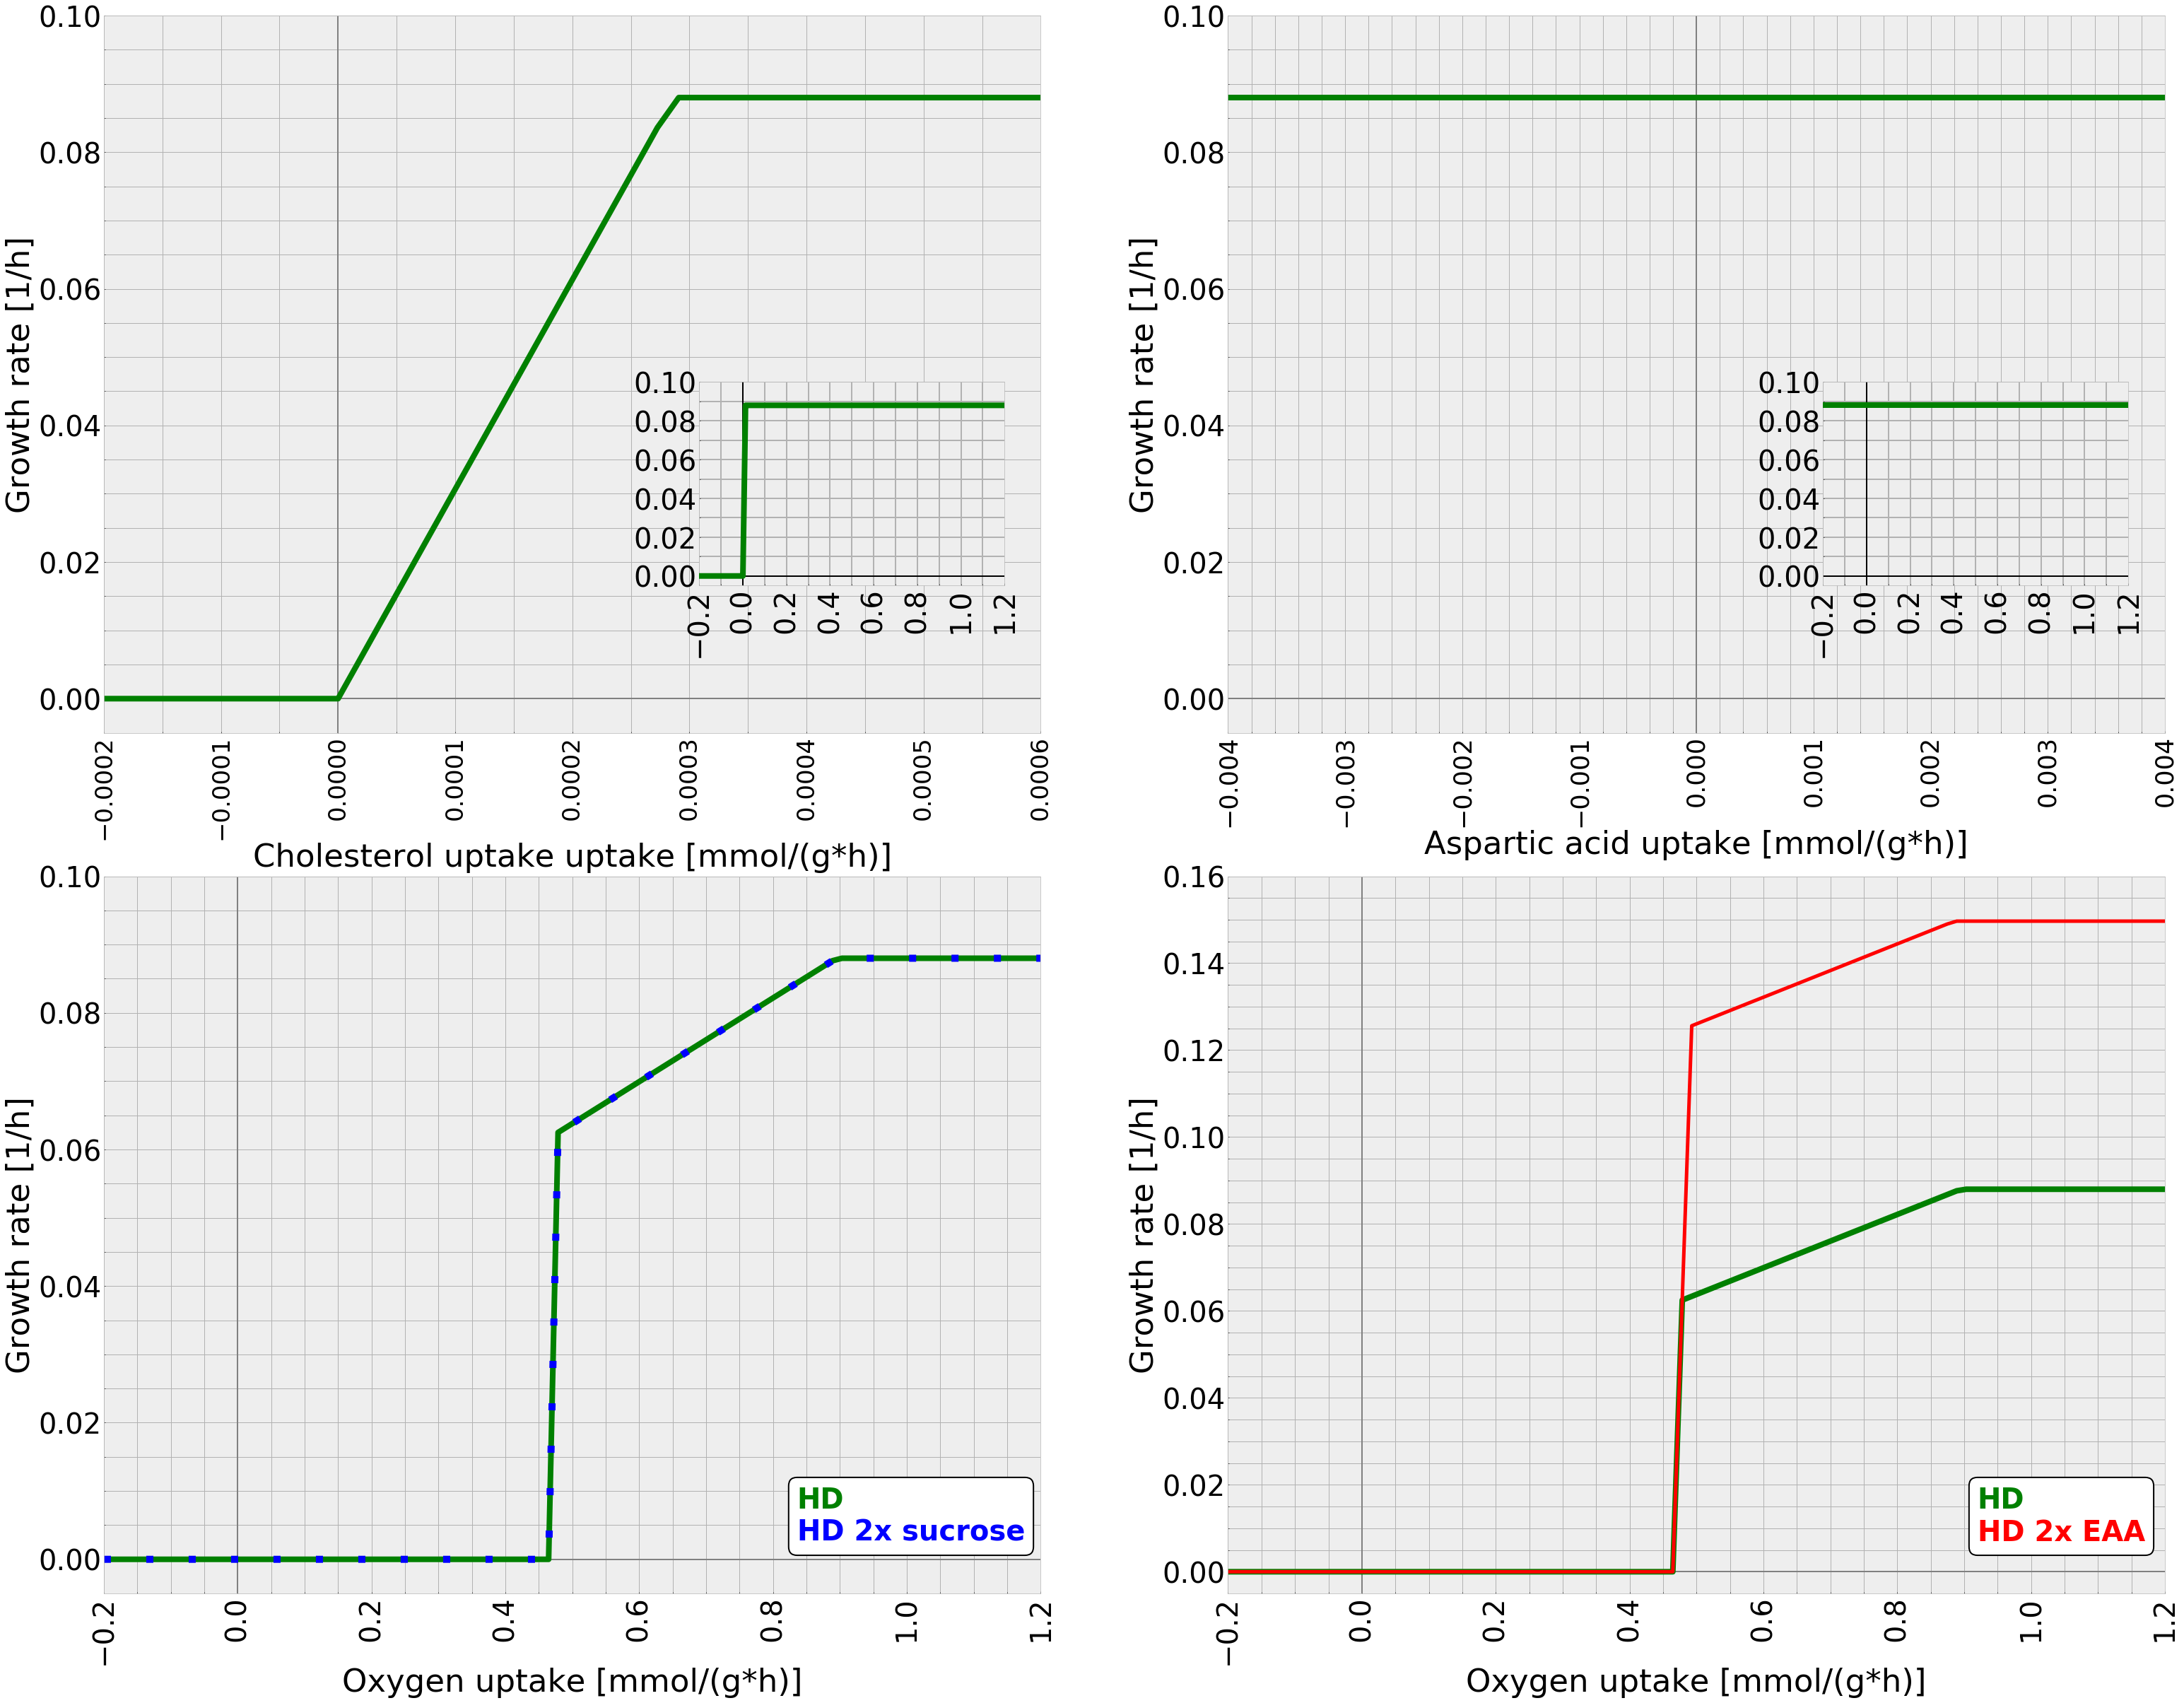

In [81]:
import matplotlib.patches as patches

fig, axs = plt.subplots(2, 2, figsize=(60, 10))

plots = axs.flatten()

counter = 0

for plotx,data in zip(plots,[clr_plot_data,asp_plot_data,suc_plot_data,eaa_plot_data]):
    counter +=1
    
    plotx.set_ylim(-.01,.1)
    plotx.axvline(x=0,color="grey")
    plotx.axhline(y=0,color="grey")
    plotx.plot(data[0],data[1],color="green",linewidth=8)
    
    for y in (plotx.get_yticklabels()):
        y.set_fontsize(40)
    for x in (plotx.get_xticklabels()):
        x.set_fontsize(40)
        x.set_rotation(90)
        
    if counter == 1:
        minor_ticks = np.arange(-0.0,0.122,0.005)
        minor_ticks_x = np.arange(-0.0003,.0016,0.00005)
        plotx.set_yticks(minor_ticks, minor=True)
        plotx.grid(b=True, which="minor",ls="-",linewidth=1)
        plotx.set_xticks(minor_ticks_x, minor=True)
        plotx.grid(b=True, which="minor",ls="-",linewidth=1)
        plotx.set_ylabel("Growth rate [1/h]", size=45) 
        plotx.set_xlabel("Cholesterol uptake uptake [mmol/(g*h)]", size=45) 
        plotx.set_xlim(-.0002,.0006)
        plotx.set_ylim(-.005,.1)
        for x in (plotx.get_xticklabels()):
            x.set_fontsize(34)

        left, bottom, width, height = [0.32, -0.22, 0.10, 0.4]
        ax3 = fig.add_axes([left, bottom, width, height])
        ax3.plot(clr_plot_data_inset[0],clr_plot_data_inset[1],color="green",linewidth=8,zorder=6)
        #ax2.patch.set_fc('xkcd:salmon')
        #fig.patch.set_facecolor('blue')
        
        ax3.axvline(x=0,color="black")
        ax3.axhline(y=0,color="black")
        
        minor_ticks = np.arange(-0.,0.162,0.01)
        minor_ticks_x = np.arange(-0.2,1.2,0.1)
        ax3.set_yticks(minor_ticks, minor=True)
        ax3.grid(b=True, which="minor",ls="-",linewidth=2)
        ax3.set_xticks(minor_ticks_x, minor=True)
        ax3.grid(b=True, which="minor",ls="-",linewidth=2)
        #ax2.set_ylabel("Growth rate [1/h]", size=35) 
        #ax2.set_xlabel("Aspartic acid uptake [mmol/(g*h)]", size=35) 
        for y in (ax3.get_yticklabels()):
            y.set_fontsize(40)
        for x in (ax3.get_xticklabels()):
            x.set_fontsize(40)
            x.set_rotation(90)
        ax3.set_xlim(-.2,1.2)
        ax3.set_ylim(-.005,.1)
    
    if counter == 2:
        minor_ticks = np.arange(-0.0,0.162,0.005)
        minor_ticks_x = np.arange(-0.004,.004,0.0002)
        plotx.set_yticks(minor_ticks, minor=True)
        plotx.grid(b=True, which="minor",ls="-",linewidth=1)
        plotx.set_xticks(minor_ticks_x, minor=True)
        plotx.grid(b=True, which="minor",ls="-",linewidth=1)
        plotx.set_ylabel("Growth rate [1/h]", size=45) 
        plotx.set_xlabel("Aspartic acid uptake [mmol/(g*h)]", size=45) 
        plotx.set_xlim(-.004,.004)
        plotx.set_ylim(-.005,.1)
        for x in (plotx.get_xticklabels()):
            x.set_fontsize(35)
        
        left, bottom, width, height = [0.32*2.15, -0.22, 0.10, 0.4]
        ax2 = fig.add_axes([left, bottom, width, height])
        ax2.plot(asp_plot_data_inset[0],asp_plot_data_inset[1],color="green",linewidth=8,zorder=6)
        #ax2.patch.set_fc('xkcd:salmon')
        #fig.patch.set_facecolor('blue')
        
        ax2.axvline(x=0,color="black")
        ax2.axhline(y=0,color="black")
        
        minor_ticks = np.arange(-0.,0.162,0.01)
        minor_ticks_x = np.arange(-0.2,1.2,0.1)
        ax2.set_yticks(minor_ticks, minor=True)
        ax2.grid(b=True, which="minor",ls="-",linewidth=2)
        ax2.set_xticks(minor_ticks_x, minor=True)
        ax2.grid(b=True, which="minor",ls="-",linewidth=2)
        #ax2.set_ylabel("Growth rate [1/h]", size=35) 
        #ax2.set_xlabel("Aspartic acid uptake [mmol/(g*h)]", size=35) 
        for y in (ax2.get_yticklabels()):
            y.set_fontsize(40)
        for x in (ax2.get_xticklabels()):
            x.set_fontsize(40)
            x.set_rotation(90)
        ax2.set_xlim(-.2,1.2)
        ax2.set_ylim(-.005,.1)

    if counter == 3:
        plotx.plot(data[0],data[2],color="blue",linestyle = (0, (1, 5)),linewidth=10)
        minor_ticks = np.arange(-0.0,0.122,0.005)
        minor_ticks_x = np.arange(-0.3,1.3,0.05)
        plotx.set_yticks(minor_ticks, minor=True)
        plotx.grid(b=True, which="minor",ls="-",linewidth=1)
        plotx.set_xticks(minor_ticks_x, minor=True)
        plotx.grid(b=True, which="minor",ls="-",linewidth=1)
        plotx.set_ylabel("Growth rate [1/h]", size=45) 
        plotx.set_xlabel("Oxygen uptake [mmol/(g*h)]", size=45) 
        plotx.set_xlim(-.2,1.2)
        plotx.set_ylim(-.005,.1)
        
        plotx.text(0.74, .15, "HD\n",color="green", transform=plotx.transAxes,weight="bold", fontsize=40,
            verticalalignment='top',bbox=dict(boxstyle='round', facecolor='grey', alpha=0),zorder=6)
        plotx.text(0.74, .15, "\nHD 2x sucrose", color="blue", transform=plotx.transAxes,weight="bold", fontsize=40,
            verticalalignment='top',bbox=dict(boxstyle='round', facecolor='w',edgecolor="black",linewidth=2, alpha=1),zorder=5)
      
    if counter == 4:
        plotx.plot(data[0],data[2],color="red",linewidth=5)
        minor_ticks = np.arange(-0.0,0.162,0.005)
        minor_ticks_x = np.arange(-0.3,1.3,0.05)
        plotx.set_yticks(minor_ticks, minor=True)
        plotx.grid(b=True, which="minor",ls="-",linewidth=1)
        plotx.set_xticks(minor_ticks_x, minor=True)
        plotx.grid(b=True, which="minor",ls="-",linewidth=1)
        
        plotx.set_ylabel("Growth rate [1/h]", size=45)  
        plotx.set_xlabel("Oxygen uptake [mmol/(g*h)]", size=45) 
        
        plotx.set_ylim(-.005,.16)
        plotx.set_xlim(-.2,1.2)
        
        plotx.text(0.80, .15, "HD\n",color="green", transform=plotx.transAxes,weight="bold", fontsize=40,
            verticalalignment='top',bbox=dict(boxstyle='round', facecolor='grey', alpha=0),zorder=6)
        plotx.text(0.80, .15, "\nHD 2x EAA", color="red", transform=plotx.transAxes,weight="bold", fontsize=40,
            verticalalignment='top',bbox=dict(boxstyle='round', facecolor='w',edgecolor="black",linewidth=2, alpha=1),zorder=5)
        
plt.subplots_adjust(bottom=-2.2, right=0.8, top=0.9)

plt.savefig("simulation_plot.png", dpi=300,
   bbox_inches="tight")


#################### 
Graph for Cholesterol
-0.0002
0.000690909090909091
0.0016
Time elapsed: 00min 47sec
                0             1
0    0.0000000000 -0.0002000000
1    0.0000000000 -0.0001818182
2    0.0000000000 -0.0001636364
3    0.0000000000 -0.0001454545
4    0.0000000000 -0.0001272727
5    0.0000000000 -0.0001090909
6    0.0000000000 -0.0000909091
7    0.0000000000 -0.0000727273
8    0.0000000000 -0.0000545455
9    0.0000000000 -0.0000363636
10   0.0000000000 -0.0000181818
11   0.0000000000  0.0000000000
12   0.0000000000  0.0000000000
13   0.0055738424  0.0000181818
14   0.0111476848  0.0000363636
15   0.0167215272  0.0000545455
16   0.0222953696  0.0000727273
17   0.0278692120  0.0000909091
18   0.0334430544  0.0001090909
19   0.0390168968  0.0001272727
20   0.0445907392  0.0001454545
21   0.0501645816  0.0001636364
22   0.0557384240  0.0001818182
23   0.0613122664  0.0002000000
24   0.0668861088  0.0002181818
25   0.0724599512  0.0002363636
26   0.0780337936  0.00025454

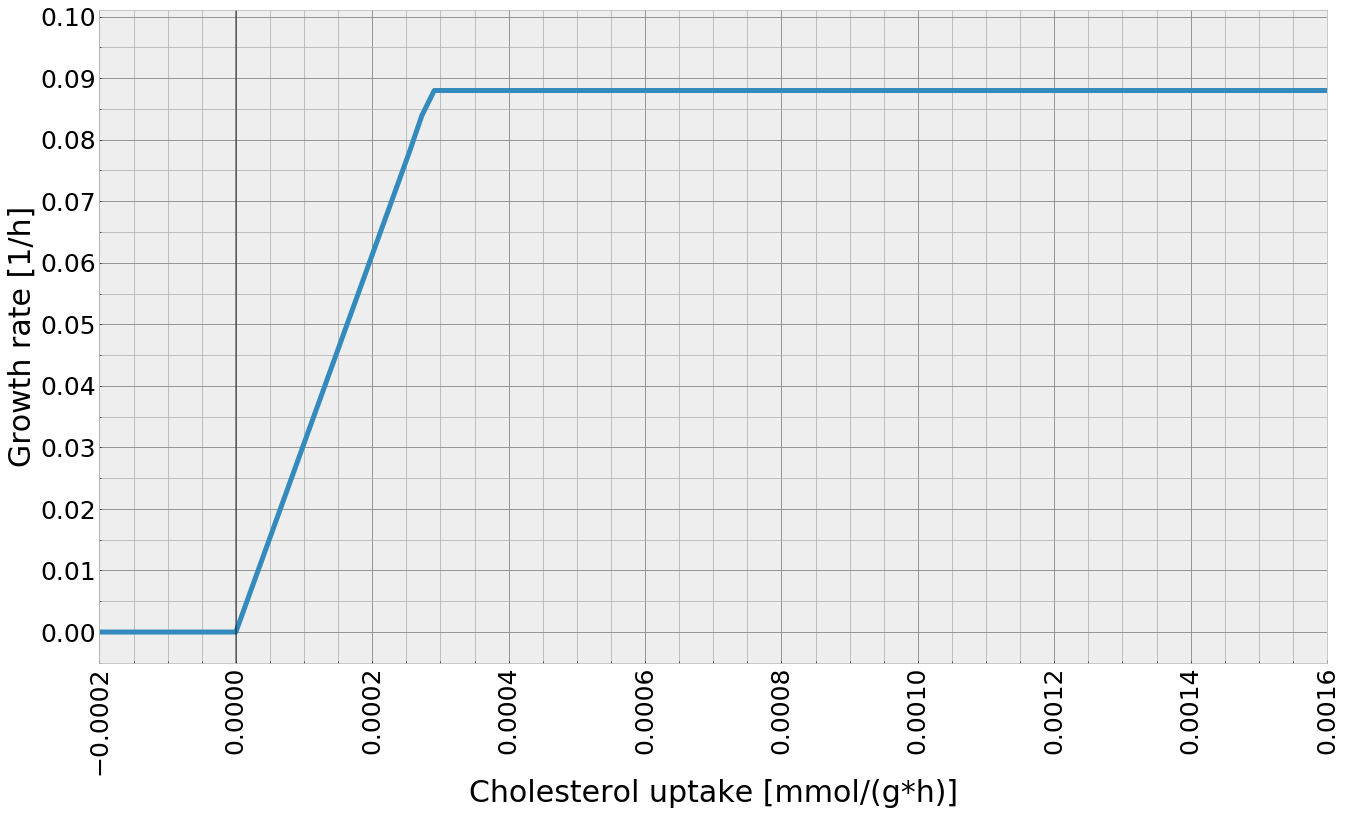

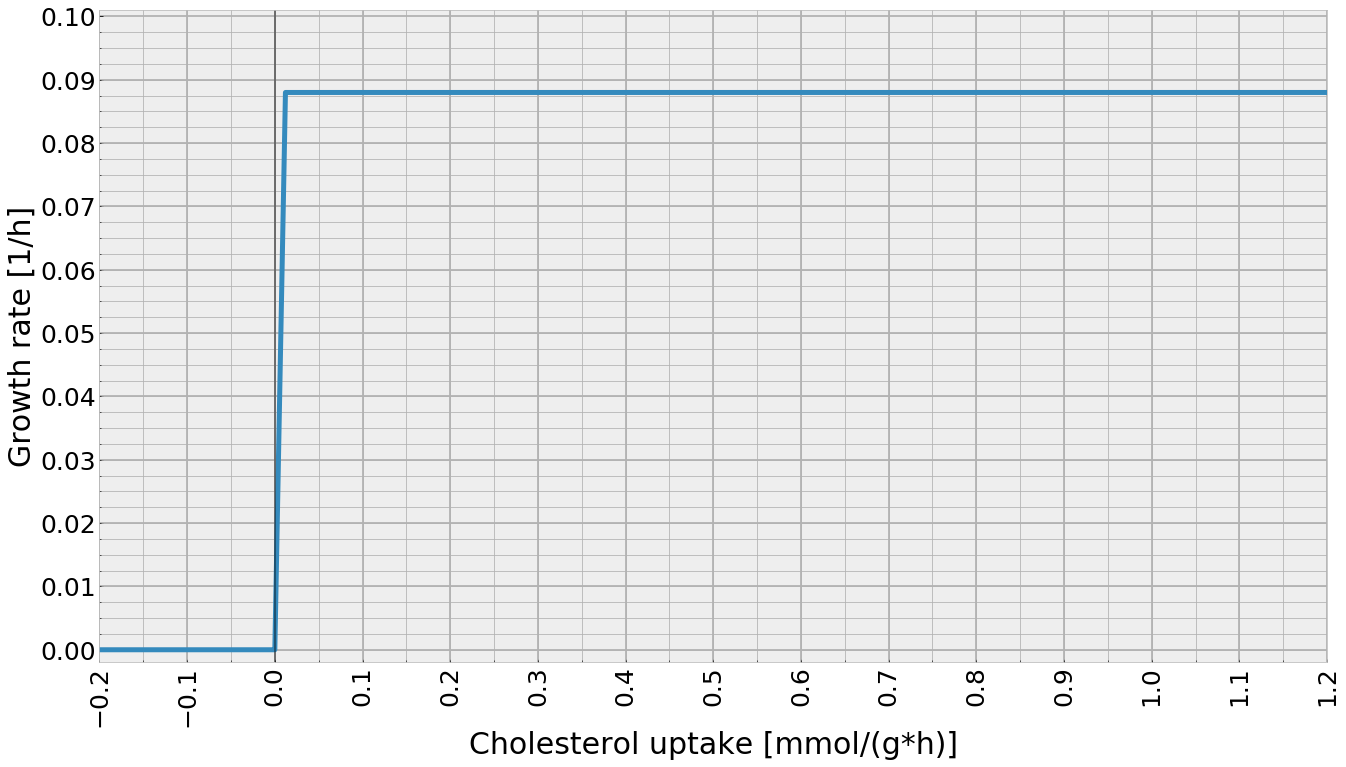

In [7]:
#####################################
### Simulation Cholesterol uptake ###
#####################################

def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    

    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.linspace(start,end,points)
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))

    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = -i
        m.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).lower_bound = -i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]
###############################################################
    fig,ax = plt.subplots(figsize=(22,12))
    
    plt.plot(meta,growth_ll, label='HD',linewidth=5)
    
    plt.title(title, size= 30)
    plt.xlabel("%s uptake [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,0.102,.01), fontsize = 25)
    plt.xticks(np.arange(start-.05,end+.0005,.0002),rotation= 90, fontsize = 25)
    
    plt.ylim(0-0.002,0.101)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    minor_ticks = np.arange(-0.005,0.102,0.005)
    minor_ticks_x = np.arange(start,end,0.00005)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)

    plt.grid(color='black', linestyle='-', linewidth=.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    solution = zip(growth_ll,linspace)
    solution_df = pd.DataFrame(solution)#sorted(solution.items(), key=operator.itemgetter(0))
    print solution_df.sort_values(by=0, ascending=1)
#########################################################################################################################

ppp(reaction = "EX_clr(e)",
    label = "Cholesterol",
    points = 100,
    end = .0016,
    start = -0.0002,
    save = False)








#####################################

def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    

    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.linspace(start,end,points)
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))
        
    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = -i
        m.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).lower_bound = -i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]
###############################################################
    fig,ax = plt.subplots(figsize=(22,12))
    
    plt.plot(meta,growth_ll, label='HD',linewidth=5)
    
    plt.title(title, size= 30)
    plt.xlabel("%s uptake [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,0.102,.01), fontsize = 25)
    plt.xticks(np.arange(start,end+.0005,.1),rotation= 90, fontsize = 25)
    
    plt.ylim(0-0.002,0.101)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    minor_ticks = np.arange(0,0.10,0.0025)
    minor_ticks_x = np.arange(start,end,0.05)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)

    plt.grid(linestyle='-', linewidth=1.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    solution = zip(growth_ll,linspace)
    solution_df = pd.DataFrame(solution)#sorted(solution.items(), key=operator.itemgetter(0))
    print solution_df.sort_values(by=0, ascending=1)
#########################################################################################################################


ppp(reaction = "EX_clr(e)",
    label = "Cholesterol",
    points = 100,
    end = 1.2,
    start = -0.2,
    save = False)


###################### 
Graph for Aspartic acid
-0.004
0.0
0.004
Time elapsed: 00min 45sec
                0             1
0    0.0879946357 -0.0040000000
1    0.0879946357 -0.0039191919
2    0.0879946357 -0.0038383838
3    0.0879946357 -0.0037575758
4    0.0879946357 -0.0036767677
5    0.0879946357 -0.0035959596
6    0.0879946357 -0.0035151515
7    0.0879946357 -0.0034343434
8    0.0879946357 -0.0033535354
9    0.0879946357 -0.0032727273
10   0.0879946357 -0.0031919192
11   0.0879946357 -0.0031111111
12   0.0879946357 -0.0030303030
13   0.0879946357 -0.0029494949
14   0.0879946357 -0.0028686869
15   0.0879946357 -0.0027878788
16   0.0879946357 -0.0027070707
17   0.0879946357 -0.0026262626
18   0.0879946357 -0.0025454545
19   0.0879946357 -0.0024646465
20   0.0879946357 -0.0023838384
21   0.0879946357 -0.0023030303
22   0.0879946357 -0.0022222222
23   0.0879946357 -0.0021414141
24   0.0879946357 -0.0020606061
25   0.0879946357 -0.0019797980
26   0.0879946357 -0.0018989899
27   0.08799

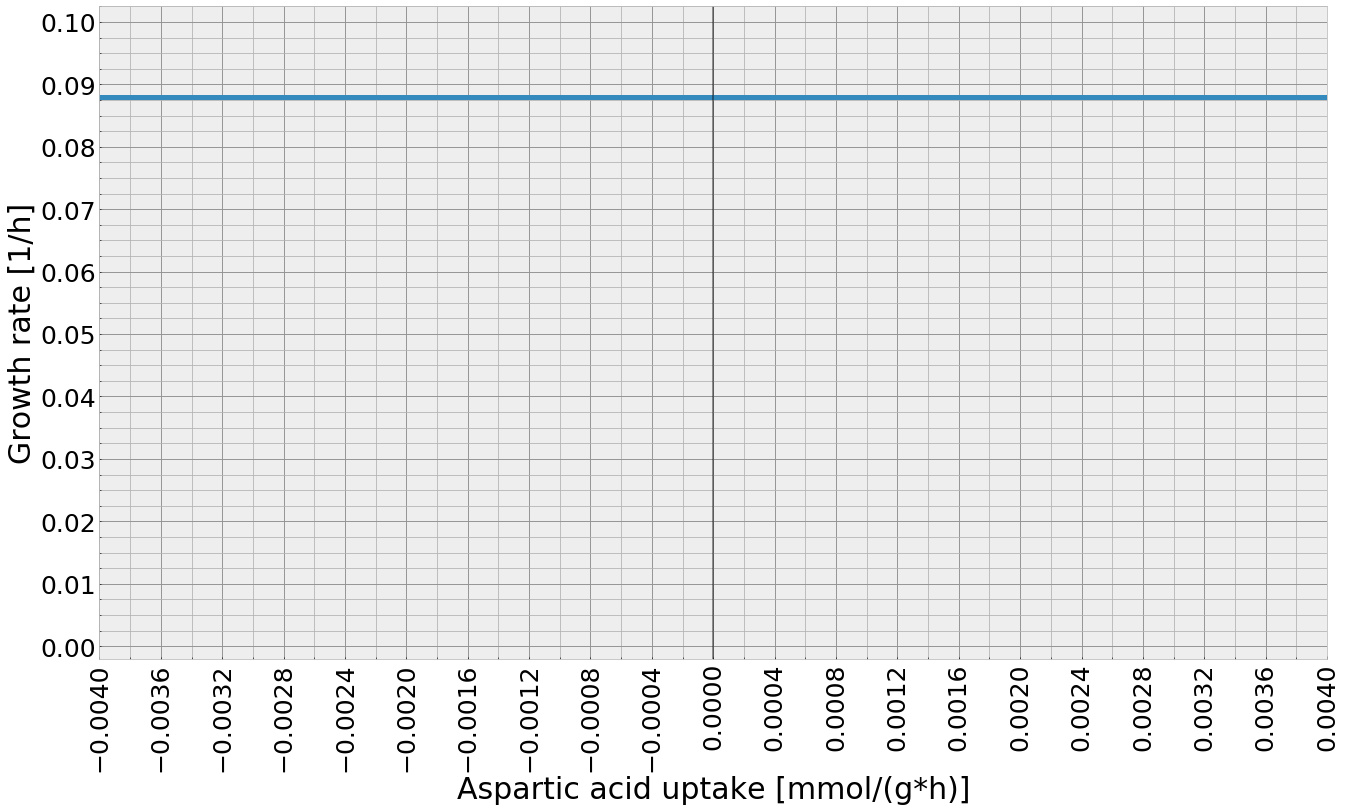

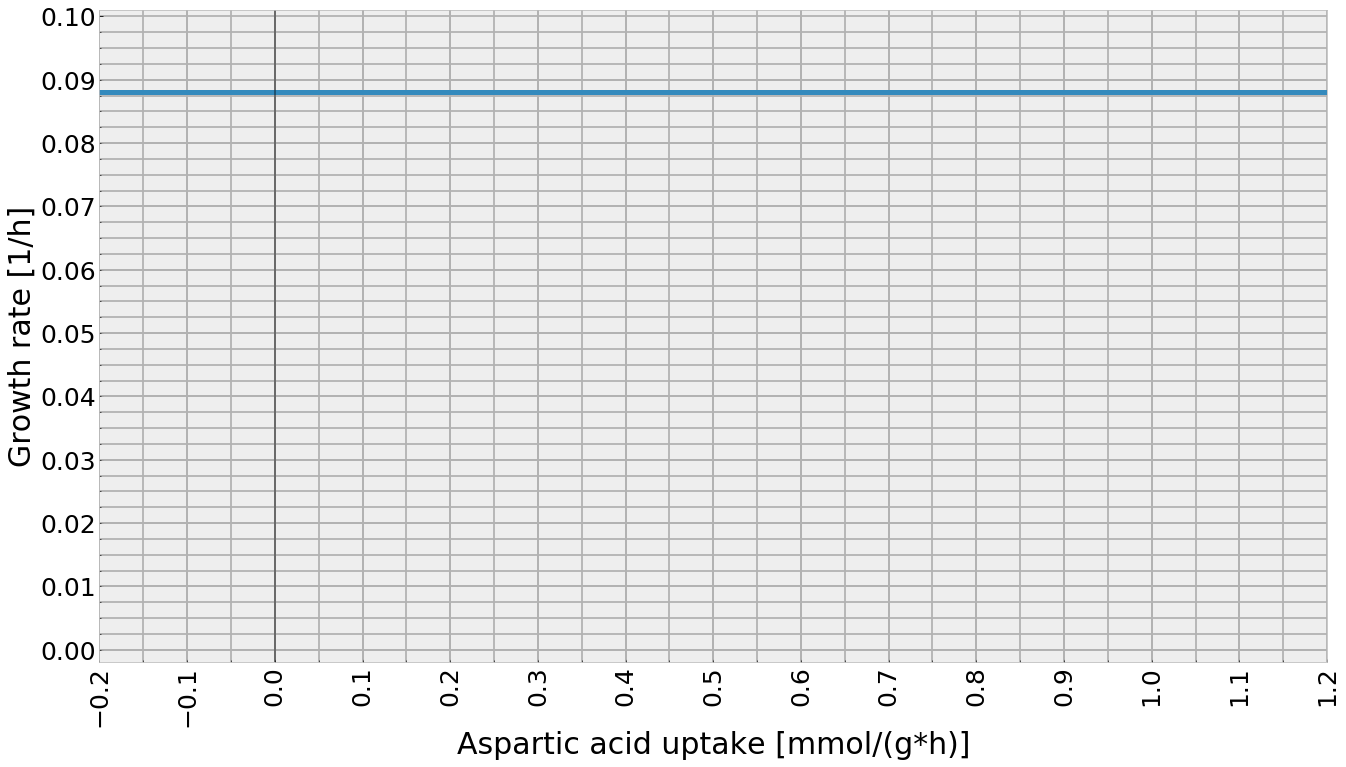

In [8]:
#####################################
### Simulation Aspartic Acid uptake ###
#####################################

def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    

    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.linspace(start,end,points)
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))

    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = -i
        m.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).lower_bound = -i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]
###############################################################
    fig,ax = plt.subplots(figsize=(22,12))
    
    plt.plot(meta,growth_ll, label='HD',linewidth=5)

    plt.title(title, size= 30)
    plt.xlabel("%s uptake [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,0.102,.01), fontsize = 25)
    plt.xticks(np.arange(start,end+0.0001,.0004),rotation= 90, fontsize = 25)
    
    plt.ylim(0-0.002,0.101)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    minor_ticks = np.arange(0,0.105,0.0025)
    minor_ticks_x = np.arange(start,end,0.0002)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)

    plt.grid(color='black', linestyle='-', linewidth=.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    solution = zip(growth_ll,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
#########################################################################################################################

ppp(reaction = "EX_asp(e)",
    label = "Aspartic acid",
    points = 100,
    end = .004,
    start = -0.004,
    save = False)




def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    

    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.linspace(start,end,points)
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))

    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = -i
        m.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).lower_bound = -i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]
###############################################################
    fig,ax = plt.subplots(figsize=(22,12))

    plt.plot(meta,growth_ll, label='HD',linewidth=5)

    
    plt.title(title, size= 30)
    plt.xlabel("%s uptake [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,0.102,.01), fontsize = 25)
    plt.xticks(np.arange(start,end+.0005,.1),rotation= 90, fontsize = 25)
    
    plt.ylim(0-0.002,0.101)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    minor_ticks = np.arange(0,0.10,0.0025)
    minor_ticks_x = np.arange(start,end,0.05)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=1.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=1.8)

    plt.grid(linestyle='-', linewidth=1.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    solution = zip(growth_ll,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
#########################################################################################################################



ppp(reaction = "EX_asp(e)",
    label = "Aspartic acid",
    points = 100,
    end = 1.2,
    start = -.2,
    save = False)


############### 
Graph for Oxygen
-0.2
0.49292929292929283
1.2
Time elapsed: 02min 07sec
                0             1
0    0.0000000000 -0.2000000000
1    0.0000000000 -0.1858585859
2    0.0000000000 -0.1717171717
3    0.0000000000 -0.1575757576
4    0.0000000000 -0.1434343434
5    0.0000000000 -0.1292929293
6    0.0000000000 -0.1151515152
7    0.0000000000 -0.1010101010
8    0.0000000000 -0.0868686869
9    0.0000000000 -0.0727272727
10   0.0000000000 -0.0585858586
11   0.0000000000 -0.0444444444
12   0.0000000000 -0.0303030303
13   0.0000000000 -0.0161616162
14   0.0000000000 -0.0020202020
15   0.0624893608  0.0000000000
16   0.0632766887  0.0121212121
17   0.0641952380  0.0262626263
18   0.0651137873  0.0404040404
19   0.0660323366  0.0545454545
20   0.0669508859  0.0686868687
21   0.0678694352  0.0828282828
22   0.0687879845  0.0969696970
23   0.0697065338  0.1111111111
24   0.0706250831  0.1252525253
25   0.0715436324  0.1393939394
26   0.0724621818  0.1535353535
27   0.0733807

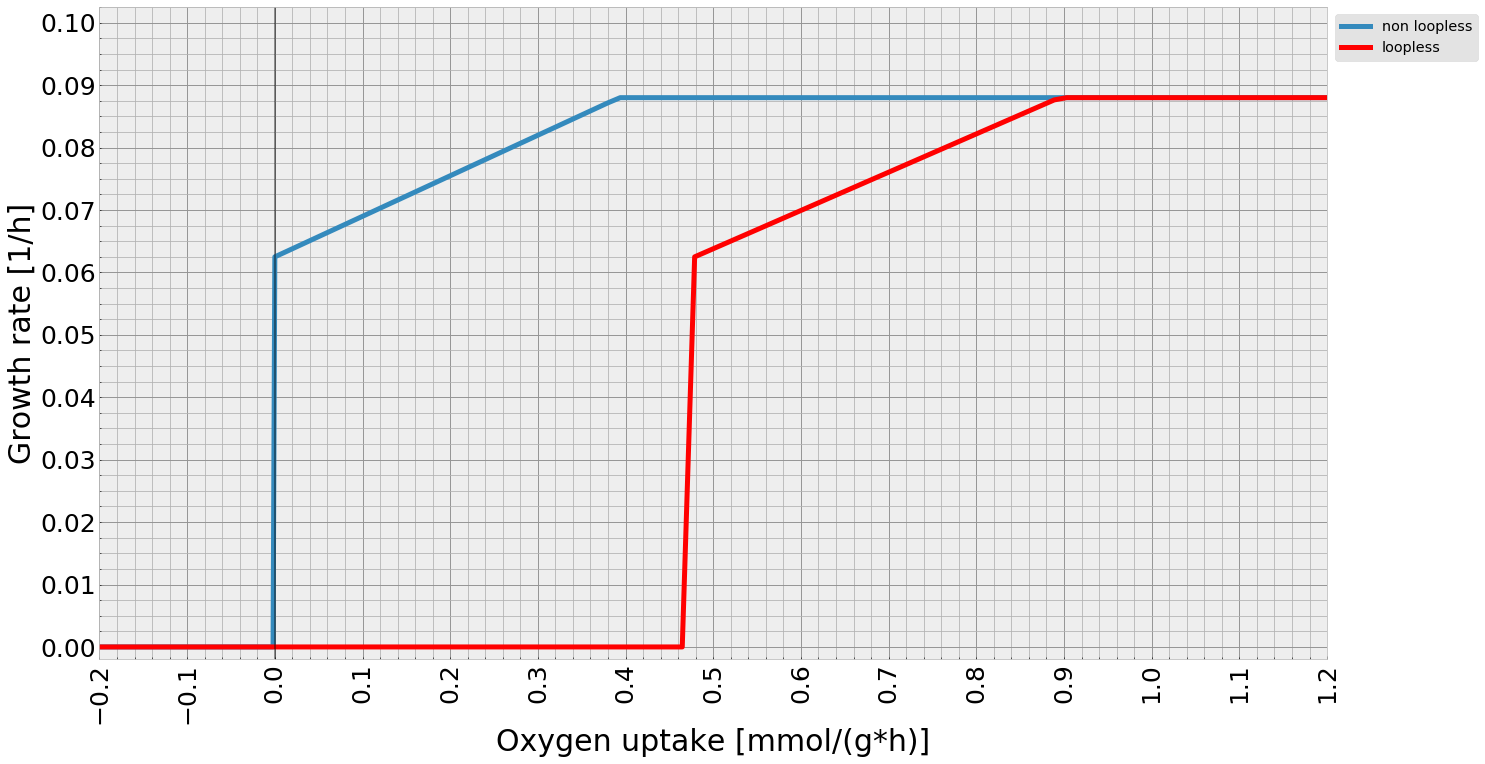

In [9]:
######################################################
### Simulation O2 uptake loopless and non-loopless ###
######################################################

def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    

    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.linspace(start,end,points)
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))

    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = -i
        m.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).lower_bound = -i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]

###############################################################
    fig,ax = plt.subplots(figsize=(22,12))
    
    plt.plot(meta,growth, label='non loopless',linewidth=5)
    plt.plot(meta,growth_ll, label='loopless',color="red",linewidth=5)
    #plt.plot(meta,growth_ll, label='HD')
    #plt.plot(meta_alt,growth_ll_alt, label='HD Half',color="red",linestyle ="-.")
    
    plt.title(title, size= 30)
    plt.xlabel("%s uptake [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,0.102,.01), fontsize = 25)
    plt.xticks(np.arange(start-.1,end+.1,.1),rotation= 90, fontsize = 25)
    
    plt.ylim(0-0.002,0.101)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    plt.legend(bbox_to_anchor=(1.001, 1), loc=2, fontsize='x-large').get_frame().set_facecolor('#DCDCDC')
    
    minor_ticks = np.arange(0,0.105,0.0025)
    minor_ticks_x = np.arange(start,end,0.02)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)

    plt.grid(color='black', linestyle='-', linewidth=.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    solution = zip(growth,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
    solution = zip(growth_ll,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
#########################################################################################################################

ppp(reaction = "EX_o2",
    label = "Oxygen",
    points = 100,
    end = 1.2,
    start = -0.2,
    save = False)


############### 
Graph for Oxygen
-0.2
0.49292929292929283
1.2
Wall time: 367 ms
Read LP format model from file c:\users\jurgen\appdata\local\temp\tmpxfwe9t.lp
Reading time = 0.01 seconds
: 293 rows, 726 columns, 2516 nonzeros
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Parameter Method unchanged
   Value: 0  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
erstelle loopless model
-0.2
0.49292929292929283
1.2
Time elapsed: 03min 29sec
                0             1
0    0.0000000000 -0.2000000000
1    0.0000000000 -0.1858585859
2    0.0000000000 -0.1717171717
3    0.0000000000 -0.1575757576
4    0.0000000000 -0.1434343434
5    0.0000000000 -0.1292929293
6    0.0000000000 -0.1151515152
7    0.0000000000 -0.1010101010
8    0.0000000000 -0.0868686869
9    0.0000000000 -0.0727272727
10   0.0000000000 -0.0585858586
11   0.0000000000 -0.0444444444
12   0.0000000000 -0.0303030303
13   0.00000

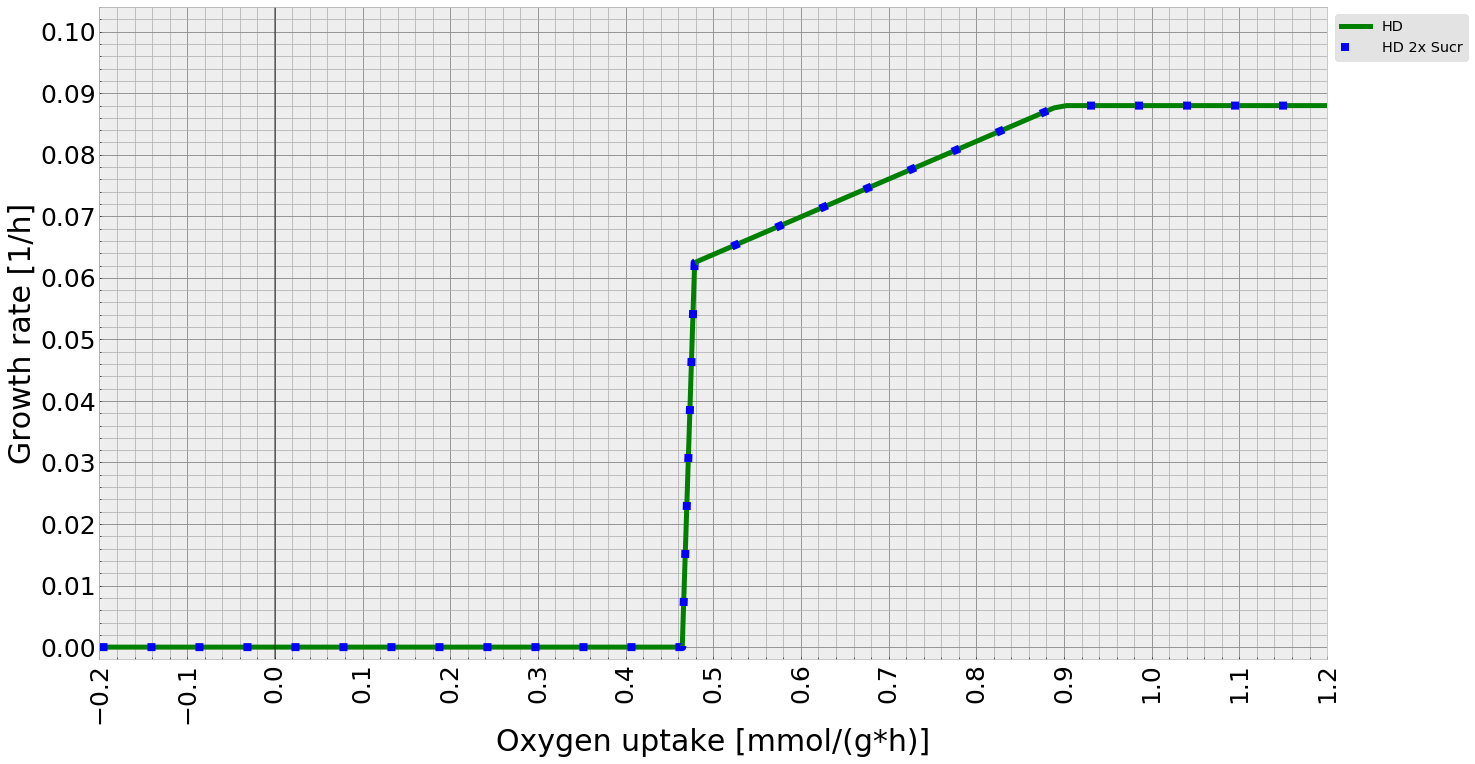

In [10]:
#########################################################
### Simulation O2 uptake HD and HD 2x Sucr comparsion ###
#########################################################

def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    

    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.linspace(start,end,points)
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))
        
    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = -i
        m.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).lower_bound = -i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]

###############################################################
    rnd = 0 #only counter
    rnd2 = 0 #only counter
    
    %time m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    print "erstelle loopless model"
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    for test in match_list:
        if match_list[test] != "None":

            m.reactions.get_by_id(match_list[test]).lower_bound = -float(up_t_suc.loc[test]["0.122"])
            m_loopless.reactions.get_by_id(match_list[test]).lower_bound = -float(up_t_suc.loc[test]["0.122"])
    
    
    for z in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            print z
            rnd += 50
    
        m.reactions.get_by_id(reaction).lower_bound = -z
        m.reactions.get_by_id(reaction).upper_bound = -z
        m_loopless.reactions.get_by_id(reaction).upper_bound = -z
        m_loopless.reactions.get_by_id(reaction).lower_bound = -z
        meta_alt += [z]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll_alt += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll_alt += [0]   
############################################################### 
    fig,ax = plt.subplots(figsize=(22,12))
    
    plt.plot(meta,growth_ll, label='HD', color= "green",linewidth=5)
    plt.plot(meta_alt,growth_ll_alt, label='HD 2x Sucr',color="blue",linestyle = (0, (1, 5)),linewidth=8)
    
    plt.title(title, size= 30)
    plt.xlabel("%s uptake [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,0.102,.01), fontsize = 25)
    plt.xticks(np.arange(start-.1,end+.1,.1),rotation= 90, fontsize = 25)
    
    plt.ylim(0-0.002,0.101)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    plt.legend(bbox_to_anchor=(1.001, 1), loc=2, fontsize='x-large').get_frame().set_facecolor('#DCDCDC')
    
    minor_ticks = np.arange(0,0.105,0.002)
    minor_ticks_x = np.arange(start,end,0.02)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)

    plt.grid(color='black', linestyle='-', linewidth=.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    solution = zip(growth_ll,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
    solution = zip(growth_ll_alt,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
#########################################################################################################################

ppp(reaction = "EX_o2",
    label = "Oxygen",
    points = 100,
    end = 1.2,
    start = -0.2,
    save = False)


############### 
Graph for Oxygen
-0.2
0.49292929292929283
1.2
Wall time: 243 ms
Read LP format model from file c:\users\jurgen\appdata\local\temp\tmp50mj3c.lp
Reading time = 0.01 seconds
: 293 rows, 726 columns, 2516 nonzeros
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Parameter Method unchanged
   Value: 0  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
erstelle loopless model
-0.2
0.49292929292929283
1.2
Time elapsed: 02min 45sec
                0             1
0    0.0000000000 -0.2000000000
1    0.0000000000 -0.1858585859
2    0.0000000000 -0.1717171717
3    0.0000000000 -0.1575757576
4    0.0000000000 -0.1434343434
5    0.0000000000 -0.1292929293
6    0.0000000000 -0.1151515152
7    0.0000000000 -0.1010101010
8    0.0000000000 -0.0868686869
9    0.0000000000 -0.0727272727
10   0.0000000000 -0.0585858586
11   0.0000000000 -0.0444444444
12   0.0000000000 -0.0303030303
13   0.00000

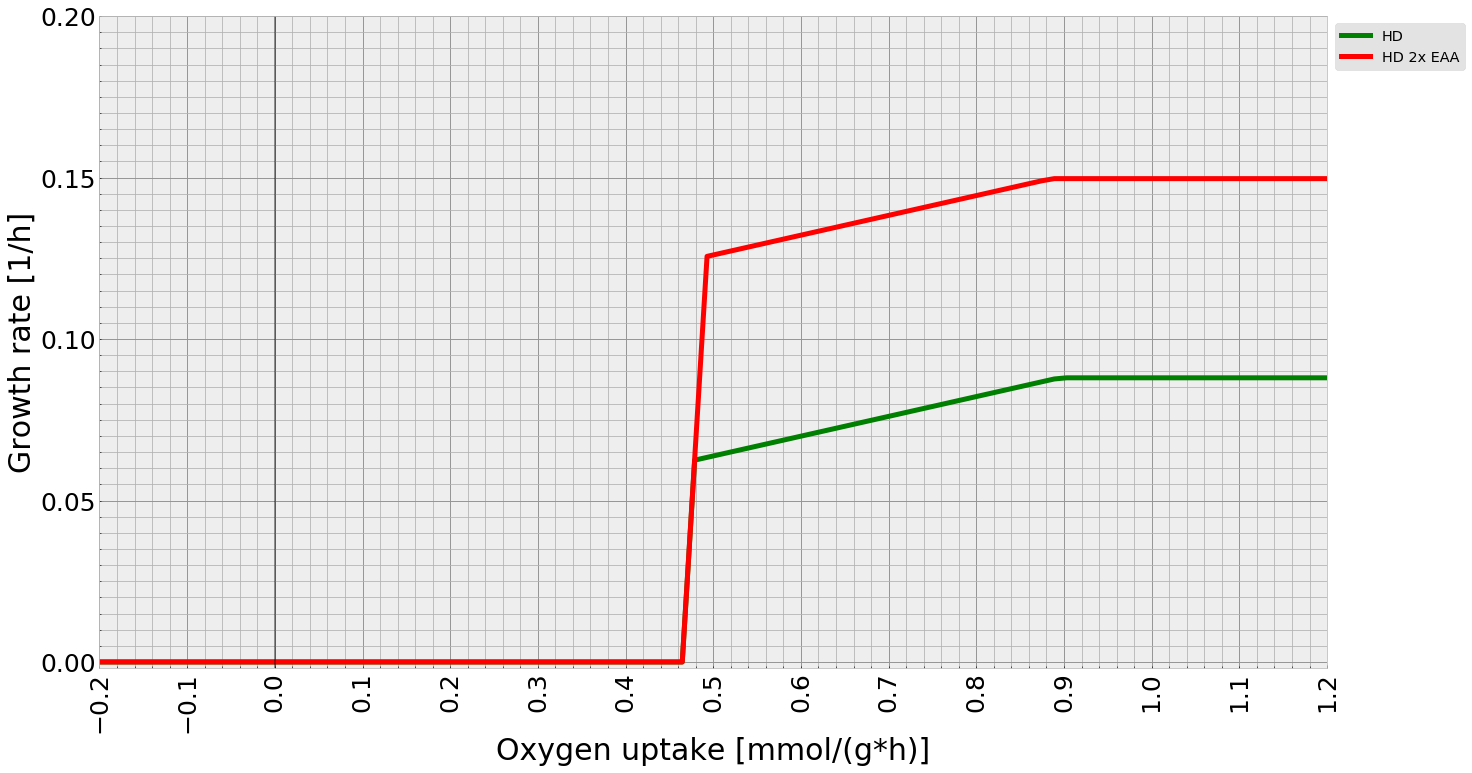

In [11]:
########################################################
### Simulation O2 uptake HD and HD 2x EAA comparsion ###
########################################################

def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    

    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.linspace(start,end,points)
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))
        
    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = -i
        m.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).lower_bound = -i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]

###############################################################
    rnd = 0 #only counter
    rnd2 = 0 #only counter
    
    %time m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    print "erstelle loopless model"
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    for test in match_list:
        if match_list[test] != "None":

            m.reactions.get_by_id(match_list[test]).lower_bound = -float(up_t_EAA.loc[test]["0.122"])
            m_loopless.reactions.get_by_id(match_list[test]).lower_bound = -float(up_t_EAA.loc[test]["0.122"])
    
    
    for z in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            print z
            rnd += 50
    
        m.reactions.get_by_id(reaction).lower_bound = -z
        m.reactions.get_by_id(reaction).upper_bound = -z
        m_loopless.reactions.get_by_id(reaction).upper_bound = -z
        m_loopless.reactions.get_by_id(reaction).lower_bound = -z
        meta_alt += [z]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll_alt += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll_alt += [0]   
############################################################### 
    fig,ax = plt.subplots(figsize=(22,12))
    
    plt.plot(meta,growth_ll, label='HD', color="green",linewidth=5)
    plt.plot(meta_alt,growth_ll_alt, label='HD 2x EAA',color="red",linestyle ="-",linewidth=5)
    
    plt.title(title, size= 30)
    plt.xlabel("%s uptake [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,0.202,.05), fontsize = 25)
    plt.xticks(np.arange(start-.1,end+.1,.1),rotation= 90, fontsize = 25)
    
    plt.ylim(0-0.002,0.161)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    plt.legend(bbox_to_anchor=(1.001, 1), loc=2, fontsize='x-large').get_frame().set_facecolor('#DCDCDC')
    
    minor_ticks = np.arange(0,0.205,0.005)
    minor_ticks_x = np.arange(start,end,0.02)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)

    plt.grid(color='black', linestyle='-', linewidth=.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    
    solution = zip(growth_ll,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
    solution_2 = zip(growth_ll_alt,linspace)
    print pd.DataFrame(solution_2).sort_values(by=1, ascending=1)
#########################################################################################################################

ppp(reaction = "EX_o2",
    label = "Oxygen",
    points = 100,
    end = 1.2,
    start = -0.2,
    save = False)


################## 
Graph for Threonine
-0.2
0.49292929292929283
1.2
Time elapsed: 00min 32sec
                0             1
0    0.0000000000 -0.2000000000
1    0.0000000000 -0.1858585859
2    0.0000000000 -0.1717171717
3    0.0000000000 -0.1575757576
4    0.0000000000 -0.1434343434
5    0.0000000000 -0.1292929293
6    0.0000000000 -0.1151515152
7    0.0000000000 -0.1010101010
8    0.0000000000 -0.0868686869
9    0.0000000000 -0.0727272727
10   0.0000000000 -0.0585858586
11   0.0000000000 -0.0444444444
12   0.0000000000 -0.0303030303
13   0.0000000000 -0.0161616162
14   0.0000000000 -0.0020202020
15   0.0000000000  0.0000000000
16   0.0278726822  0.0121212121
17   0.0296863710  0.0262626263
18   0.0315000599  0.0404040404
19   0.0333137488  0.0545454545
20   0.0351274377  0.0686868687
21   0.0369411266  0.0828282828
22   0.0387548154  0.0969696970
23   0.0405685043  0.1111111111
24   0.0423821932  0.1252525253
25   0.0441958821  0.1393939394
26   0.0460095710  0.1535353535
27   0.0

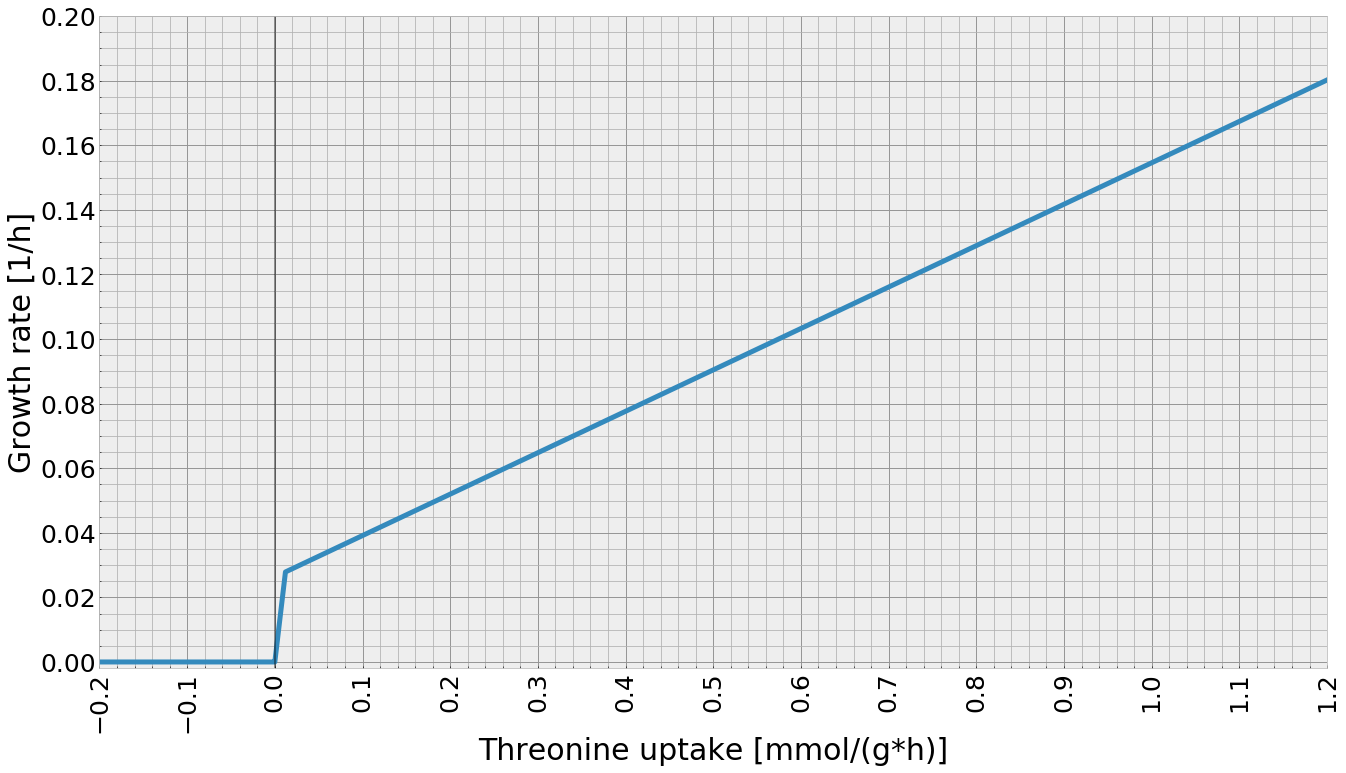

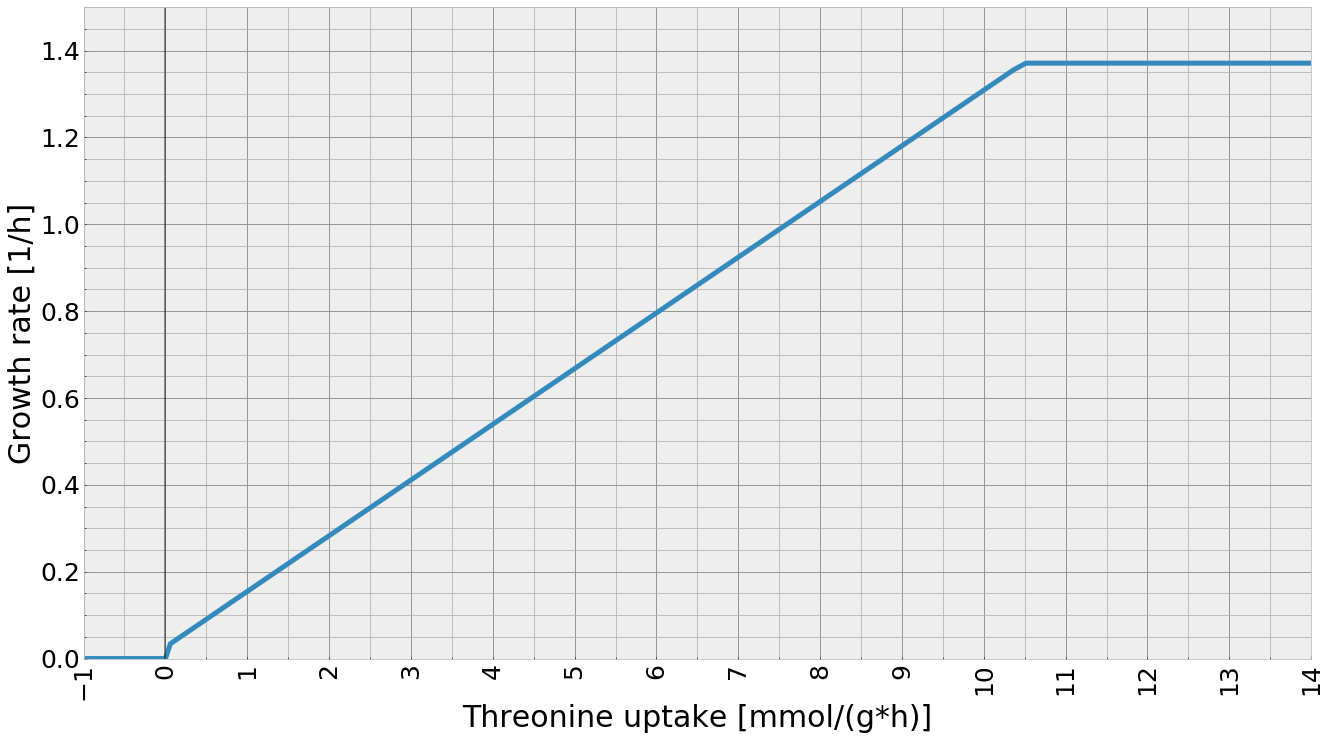

In [12]:
###################################
### Simulation threonine uptake ###
###################################

def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    

    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.linspace(start,end,points)
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))
    #print linspace
    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = -i
        m.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).lower_bound = -i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]

############################################################### 
    fig,ax = plt.subplots(figsize=(22,12))
    
    plt.plot(meta,growth_ll, label='loopless',linewidth=5)#,color="red")
    
    plt.title(title, size= 30)
    plt.xlabel("%s uptake [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,0.201,.02), fontsize = 25)
    plt.xticks(np.arange(start-.1,end+.1,.1),rotation= 90, fontsize = 25)
    
    plt.ylim(0-0.002,0.101)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    minor_ticks = np.arange(0,0.205,0.005)
    minor_ticks_x = np.arange(start,end,0.02)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)

    plt.grid(color='black', linestyle='-', linewidth=.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    
    solution = zip(growth_ll,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
#########################################################################################################################

ppp(reaction = "EX_thr(e)",
    label = "Threonine",
    points = 100,
    end = 1.2,
    start = -.2,
    save = False)






def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    

    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.linspace(start,end,points)
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))
        
    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = -i
        m.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).lower_bound = -i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]

############################################################### 
    fig,ax = plt.subplots(figsize=(22,12))
    
    plt.plot(meta,growth_ll, label='loopless',linewidth=5)#,color="red")
    
    plt.title(title, size= 30)
    plt.xlabel("%s uptake [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,1.52,.2), fontsize = 25)
    plt.xticks(np.arange(start,end+.1,1),rotation= 90, fontsize = 25)
    
    plt.ylim(0-0.002,0.101)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    minor_ticks = np.arange(0,1.55,0.05)
    minor_ticks_x = np.arange(start,end,0.5)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)

    plt.grid(color='black', linestyle='-', linewidth=.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    
    solution = zip(growth_ll,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
#########################################################################################################################

ppp(reaction = "EX_thr(e)",
    label = "Threonine",
    points = 100,
    end = 14,
    start = -1,
    save = False)


################# 
Graph for Tyrosine
-0.1
0.14747474747474748
0.4
Time elapsed: 00min 30sec
                0             1
0    0.0000000000 -0.1000000000
1    0.0000000000 -0.0949494949
2    0.0000000000 -0.0898989899
3    0.0000000000 -0.0848484848
4    0.0000000000 -0.0797979798
5    0.0000000000 -0.0747474747
6    0.0000000000 -0.0696969697
7    0.0000000000 -0.0646464646
8    0.0000000000 -0.0595959596
9    0.0000000000 -0.0545454545
10   0.0000000000 -0.0494949495
11   0.0000000000 -0.0444444444
12   0.0000000000 -0.0393939394
13   0.0000000000 -0.0343434343
14   0.0000000000 -0.0292929293
15   0.0000000000 -0.0242424242
16   0.0000000000 -0.0191919192
17   0.0000000000 -0.0141414141
18   0.0163934930 -0.0090909091
19   0.0611748765 -0.0040404040
20   0.0616930733  0.0000000000
21   0.0618226225  0.0010101010
22   0.0624703686  0.0060606061
23   0.0631181146  0.0111111111
24   0.0637658606  0.0161616162
25   0.0644136066  0.0212121212
26   0.0650613527  0.0262626263
27   0.065

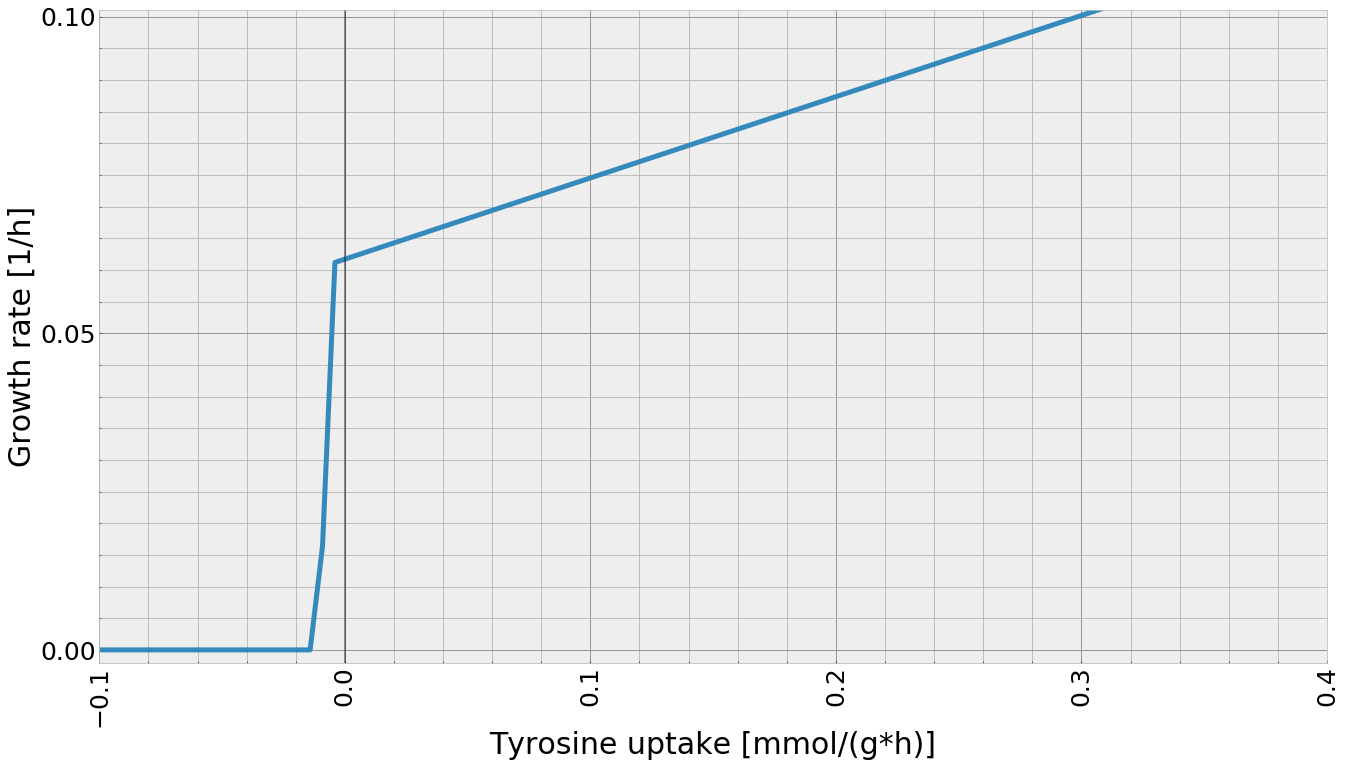

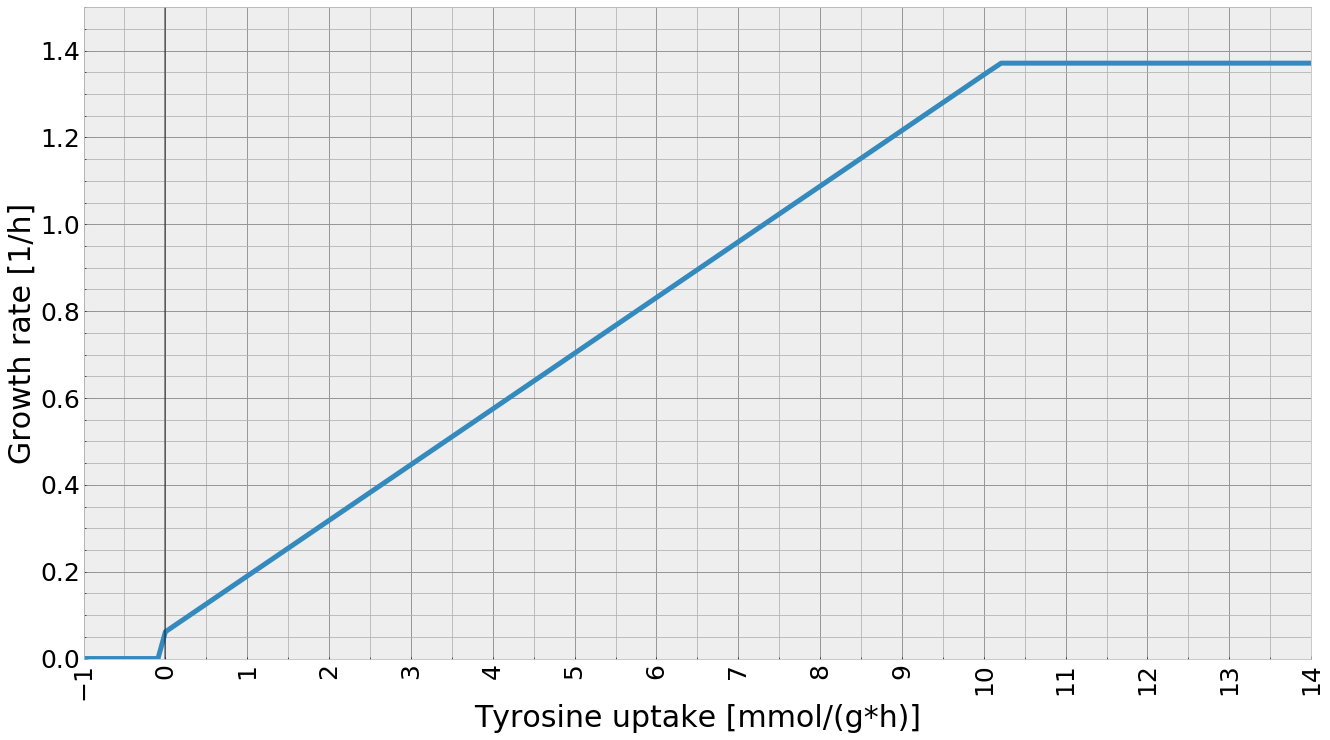

In [13]:
###################################
### Simulation tyrosine uptake ###
###################################

def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    

    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.linspace(start,end,points)
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))
        
    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = -i
        m.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).lower_bound = -i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]

############################################################### 
    fig,ax = plt.subplots(figsize=(22,12))
    
    plt.plot(meta,growth_ll, label='loopless',linewidth=5)#,color="red")
    
    plt.title(title, size= 30)
    plt.xlabel("%s uptake [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,0.102,.05), fontsize = 25)
    plt.xticks(np.arange(start-.1,end+.1,.1),rotation= 90, fontsize = 25)
    
    plt.ylim(0-0.002,0.101)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    minor_ticks = np.arange(0,0.105,0.005)
    minor_ticks_x = np.arange(start,end,0.02)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)

    plt.grid(color='black', linestyle='-', linewidth=.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    
    solution = zip(growth_ll,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
#########################################################################################################################


ppp(reaction = "EX_tyr(e)",
    label = "Tyrosine",
    points = 100,
    end = .4,
    start = -.1,
    save = False)




def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.linspace(start,end,points)
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))

    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = -i
        m.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).upper_bound = -i
        m_loopless.reactions.get_by_id(reaction).lower_bound = -i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]

############################################################### 
    fig,ax = plt.subplots(figsize=(22,12))
    
    plt.plot(meta,growth_ll, label='loopless',linewidth=5)#,color="red")
    
    plt.title(title, size= 30)
    plt.xlabel("%s uptake [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,1.52,.2), fontsize = 25)
    plt.xticks(np.arange(start,end+.1,1),rotation= 90, fontsize = 25)
    
    plt.ylim(0-0.002,0.101)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    minor_ticks = np.arange(0,1.55,0.05)
    minor_ticks_x = np.arange(start,end,0.5)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)

    plt.grid(color='black', linestyle='-', linewidth=.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    
    solution = zip(growth_ll,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
#########################################################################################################################


ppp(reaction = "EX_tyr(e)",
    label = "Tyrosine",
    points = 100,
    end = 14,
    start = -1,
    save = False)